In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report

dataset = np.genfromtxt('prices250.txt').transpose() #dataset shape - each row is different instruments, columns are days
(ninst,nt) = dataset.shape
df = pd.DataFrame(dataset.transpose())

formatted_df = pd.DataFrame(columns=['instrument', 'day', 'price'])
i = 0
while i < ninst:
    temp = df[i]
    temp = temp.values.flatten()
    instr = np.full((nt,),i)
    da = np.linspace(0,nt-1, num=nt)

    stock_df = pd.DataFrame({'instrument':instr, 'day':da, 'price':temp})
    formatted_df = formatted_df.append(stock_df, ignore_index=True)

    i+=1
    
price_data = formatted_df.copy()
daily_predict = formatted_df.copy()

price_data['change_in_price'] = price_data.groupby('instrument')['price'].diff()

# Calculate the 14 day RSI
n = 14
up_df, down_df = price_data[['instrument','change_in_price']].copy(), price_data[['instrument','change_in_price']].copy()
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0
down_df['change_in_price'] = down_df['change_in_price'].abs()
ewma_up = up_df.groupby('instrument')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('instrument')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
relative_strength = ewma_up / ewma_down
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI_14'] = relative_strength_index

# Calculate the Stochastic RSI 14
n = 14
low_14, high_14 = price_data[['instrument','RSI_14']].copy(), price_data[['instrument','RSI_14']].copy()
low_14 = low_14.groupby('instrument')['RSI_14'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('instrument')['RSI_14'].transform(lambda x: x.rolling(window = n).max())
STOCH_RSI = (price_data['RSI_14'] - low_14) / (high_14 - low_14)

price_data['STOCH_RSI'] = STOCH_RSI

# Calculate the Stochastic Oscillator
n = 14
low_14, high_14 = price_data[['instrument','price']].copy(), price_data[['instrument','price']].copy()
low_14 = low_14.groupby('instrument')['price'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('instrument')['price'].transform(lambda x: x.rolling(window = n).max())
k_percent = 100 * ((price_data['price'] - low_14) / (high_14 - low_14))

price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

# Calculate the MACD
ema_26 = price_data.groupby('instrument')['price'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('instrument')['price'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26
ema_9_macd = macd.ewm(span = 9).mean()

price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd


# Calculate the Price Rate of Change
n = 9
price_data['Price_Rate_Of_Change'] = price_data.groupby('instrument')['price'].transform(lambda x: x.pct_change(periods = n))


#Bollinger Band; Generates a value greater than 1 if above upper bound, lower than -1 for below lower band, -1<val<1 for between bands
n = 12
sma12 = price_data.groupby('instrument')['price'].transform(lambda x: x.rolling(n).mean())
std12 = price_data.groupby('instrument')['price'].transform(lambda x: x.rolling(n).std())   
upper = sma12 + 2*std12
lower = sma12 - 2*std12    
BollingerVal = (2 * (price_data['price'] - sma12)) / (upper - lower)
    
price_data['BOLL'] = BollingerVal
    
price_data.head()

,instrument,day,price,change_in_price,down_days,up_days,RSI_14,STOCH_RSI,low_14,high_14,k_percent,MACD,MACD_EMA,Price_Rate_Of_Change,BOLL
0,0,0.0,18.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
1,0,1.0,18.22,-0.03,0.03,0.00,0.000000,NaN,NaN,NaN,NaN,-0.000673,-0.000374,NaN,NaN
2,0,2.0,18.28,0.06,0.00,0.06,69.767442,NaN,NaN,NaN,NaN,0.001003,0.000190,NaN,NaN
3,0,3.0,18.07,-0.21,0.21,0.00,18.275539,NaN,NaN,NaN,NaN,-0.005841,-0.001853,NaN,NaN
4,0,4.0,18.20,0.13,0.00,0.13,46.486652,NaN,NaN,NaN,NaN,-0.004264,-0.002570,NaN,NaN


In [2]:
close_groups = price_data.groupby('instrument')['price']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : -x.diff(periods=-1)/x)

# add the data to the main dataframe.
price_data['prc_change'] = close_groups

classifications = [
    (price_data['prc_change'] < 0),
    (price_data['prc_change'] >= 0)
]

values = [-1, 1]

price_data['Prediction'] = np.select(classifications, values)


price_data.head()

,instrument,day,price,change_in_price,down_days,up_days,RSI_14,STOCH_RSI,low_14,high_14,k_percent,MACD,MACD_EMA,Price_Rate_Of_Change,BOLL,prc_change,Prediction
0,0,0.0,18.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,-0.001644,-1
1,0,1.0,18.22,-0.03,0.03,0.00,0.000000,NaN,NaN,NaN,NaN,-0.000673,-0.000374,NaN,NaN,0.003293,1
2,0,2.0,18.28,0.06,0.00,0.06,69.767442,NaN,NaN,NaN,NaN,0.001003,0.000190,NaN,NaN,-0.011488,-1
3,0,3.0,18.07,-0.21,0.21,0.00,18.275539,NaN,NaN,NaN,NaN,-0.005841,-0.001853,NaN,NaN,0.007194,1
4,0,4.0,18.20,0.13,0.00,0.13,46.486652,NaN,NaN,NaN,NaN,-0.004264,-0.002570,NaN,NaN,-0.002747,-1


In [3]:
# NaN Removal for modelling

price_data.replace([np.inf, -np.inf], np.nan, inplace=True)
price_data = price_data.dropna()

Before NaN Drop we have 25000 rows and 17 columns
After NaN Drop we have 23370 rows and 17 columns


,instrument,day,price,change_in_price,down_days,up_days,RSI_14,STOCH_RSI,low_14,high_14,k_percent,MACD,MACD_EMA,Price_Rate_Of_Change,BOLL,prc_change,Prediction
14,0,14.0,18.35,-0.39,0.39,0.00,47.415912,0.590963,18.07,18.74,41.791045,0.043893,0.029241,0.011019,-0.022158,0.003815,1
15,0,15.0,18.42,0.07,0.00,0.07,51.522528,0.536592,18.07,18.74,52.238806,0.039162,0.031283,0.009868,0.098493,-0.005429,-1
16,0,16.0,18.32,-0.10,0.10,0.00,45.646461,0.441755,18.07,18.74,37.313433,0.028879,0.030791,-0.003806,-0.248430,-0.008734,-1
17,0,17.0,18.16,-0.16,0.16,0.00,37.707175,0.000000,18.15,18.74,1.694915,0.010562,0.026671,-0.009815,-0.771021,-0.014868,-1
18,0,18.0,17.89,-0.27,0.27,0.00,28.167815,0.000000,17.89,18.74,0.000000,-0.020964,0.017004,-0.028246,-1.139943,0.012856,1


In [13]:
X_Cols = price_data[['RSI_14','STOCH_RSI','k_percent','Price_Rate_Of_Change','MACD','MACD_EMA','BOLL']]
Y_Cols = price_data['Prediction']

X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, test_size = 0.2, random_state = 0)

rfc_up_down = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

rfc_up_down.fit(X_train, y_train)

y_pred = rfc_up_down.predict(X_test)

In [14]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rfc_up_down.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  61.14676936243046


In [15]:
target_names = ['Down Day', 'Up Day']

report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.605627,0.562196,0.583104,2259.000000
Up Day,0.616220,0.657557,0.636218,2415.000000
accuracy,0.611468,0.611468,0.611468,0.611468
macro avg,0.610924,0.609876,0.609661,4674.000000
weighted avg,0.611101,0.611468,0.610547,4674.000000


Accuracy: 0.6114676936243046
Percision: 0.616220411331005
Recall: 0.6575569358178054
Specificity: 0.5621956617972554


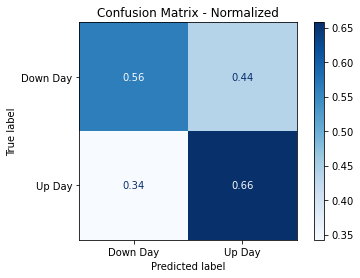

In [16]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(y_test, y_pred)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

disp = plot_confusion_matrix(rfc_up_down, X_test, y_test, display_labels = ['Down Day', 'Up Day'], normalize = 'true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - Normalized')
plt.show()

In [17]:
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rfc_up_down.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp

RSI_14                  0.166550
BOLL                    0.161083
Price_Rate_Of_Change    0.155621
MACD_EMA                0.138049
MACD                    0.137769
STOCH_RSI               0.123389
k_percent               0.117539
dtype: float64

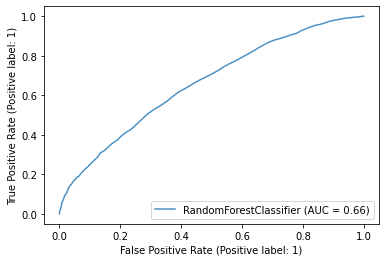

In [18]:
# Create an ROC Curve plot.
rfc_disp = plot_roc_curve(rfc_up_down, X_test, y_test, alpha = 0.8)
plt.show()

In [19]:
import pickle
with open('rfc_up_down.pickle', 'wb') as f:
    pickle.dump(rfc_up_down, f)

In [20]:
n_estimators = list(range(200, 2000, 200))

max_features = ['auto', 'sqrt', None, 'log2']

max_depth = list(range(10, 110, 10))
max_depth.append(None)

min_samples_split = [2, 5, 10, 20, 30, 40]

min_samples_leaf = [1, 2, 7, 12, 14, 16 ,20]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}


In [21]:
# New Random Forest Classifier to house optimal parameters
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt', None,
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 7, 12, 14,
                                                             16, 20],
                                        'min_samples_split': [2, 5, 10, 20, 30,
                                                              40],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800]},
          

In [24]:
rf_random.predict(X_test)

print('Correct Prediction (%): ', accuracy_score(y_test, rf_random.predict(X_test), normalize = True) * 100.0)

target_names = ['Down Day', 'Up Day']

report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

report_df = pd.DataFrame(report).transpose()
display(report_df)
print('\n')

Correct Prediction (%):  61.59606332905434


,precision,recall,f1-score,support
Down Day,0.605627,0.562196,0.583104,2259.000000
Up Day,0.616220,0.657557,0.636218,2415.000000
accuracy,0.611468,0.611468,0.611468,0.611468
macro avg,0.610924,0.609876,0.609661,4674.000000
weighted avg,0.611101,0.611468,0.610547,4674.000000


In [25]:
import pickle
with open('rfc_up_down.pickle', 'wb') as f:
    pickle.dump(rf_random, f)